In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomBrightness, Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50
import matplotlib.pyplot as plt

train_dir = '/kaggle/input/coleaf/CoLeaf DATASET'
print(os.listdir(train_dir))



['calcium-Ca', 'phosphorus-P', 'iron-Fe', 'more-deficiencies', 'boron-B', 'healthy', 'magnesium-Mg', 'potasium-K', 'manganese-Mn', 'nitrogen-N']


In [4]:
# Define dataset parameters
batch_size = 32
img_height = 224
img_width = 224

# Load training and validation datasets
train_ds = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Check the class names
class_names = train_ds.class_names
print("Class names:", class_names)

Found 1006 files belonging to 10 classes.
Using 805 files for training.
Found 1006 files belonging to 10 classes.
Using 201 files for validation.
Class names: ['boron-B', 'calcium-Ca', 'healthy', 'iron-Fe', 'magnesium-Mg', 'manganese-Mn', 'more-deficiencies', 'nitrogen-N', 'phosphorus-P', 'potasium-K']


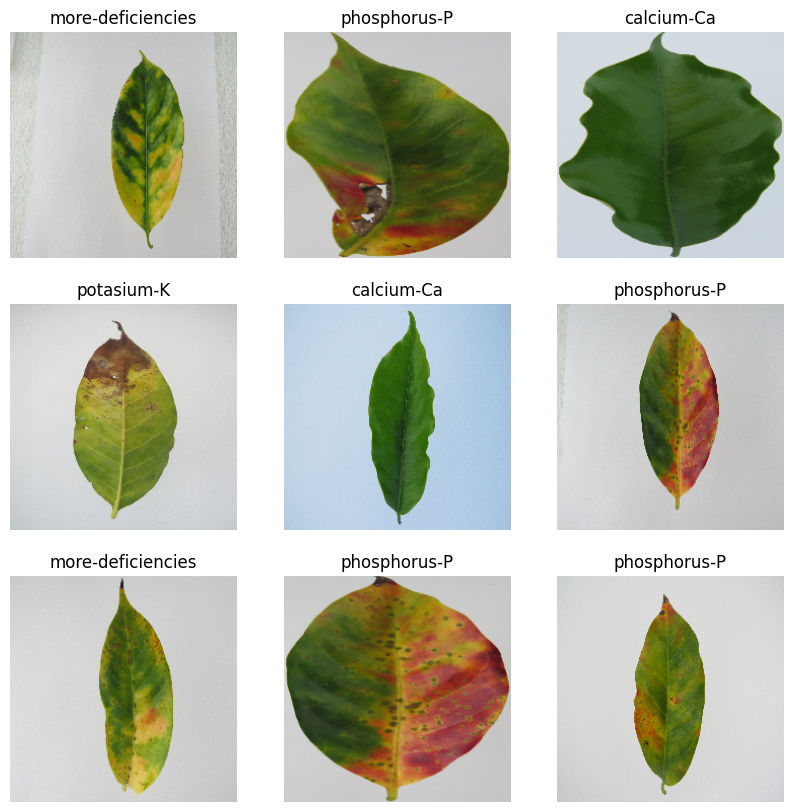

In [5]:

# Visualize some images from the dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()



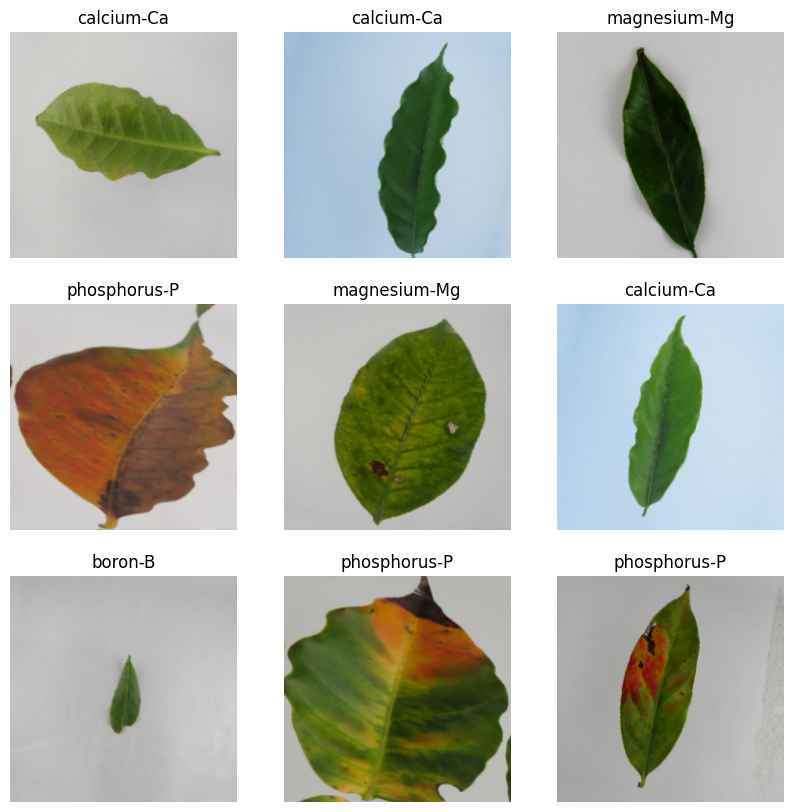

In [8]:
# Define the data augmentation layers with refined parameters
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.05),
    RandomZoom(0.05),
    RandomContrast(0.1),
    RandomBrightness(0.1),
])

# Apply data augmentation to the training dataset
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Visualize some augmented images from the training dataset
plt.figure(figsize=(10, 10))
for images, labels in augmented_train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

# Define the normalization layer
normalization_layer = Rescaling(1./255)

# Apply normalization to the augmented training dataset
normalized_train_ds = augmented_train_ds.map(lambda x, y: (normalization_layer(x), y))

# Apply normalization to the validation dataset
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))


In [12]:
# Preparing the Dataset for Training
AUTOTUNE = tf.data.AUTOTUNE

# Cache, shuffle, batch, and prefetch the training dataset
train_ds = normalized_train_ds.cache().shuffle(1000).batch(batch_size).prefetch(buffer_size=AUTOTUNE)

# Cache, batch, and prefetch the validation dataset
val_ds = normalized_val_ds.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)


In [13]:
# Defining the Model Architectures

# 1. Custom CNN Model
def create_custom_cnn(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# 2. ResNet50 Model
def create_resnet50(input_shape, num_classes):
    base_model = ResNet50(include_top=False, input_shape=input_shape, pooling='avg', weights=None)  # Set weights=None
    model = tf.keras.Sequential([
        base_model,
        Dense(num_classes, activation='softmax')
    ])
    return model

In [14]:

# Compiling the models

input_shape = (img_height, img_width, 3)
num_classes = len(class_names)

# Custom CNN Model
custom_cnn_model = create_custom_cnn(input_shape, num_classes)
custom_cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ResNet50 Model
resnet50_model = create_resnet50(input_shape, num_classes)
resnet50_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [15]:
# Train the Custom CNN Model
history_custom_cnn = custom_cnn_model.fit(
    normalized_train_ds,
    validation_data=normalized_val_ds,
    epochs=20  # Adjust the number of epochs as needed
)

# Evaluate the Custom CNN Model
loss, accuracy = custom_cnn_model.evaluate(normalized_val_ds)
print(f"Custom CNN Model - Loss: {loss}, Accuracy: {accuracy}")

# Train the ResNet50 Model
history_resnet50 = resnet50_model.fit(
    normalized_train_ds,
    validation_data=normalized_val_ds,
    epochs=20  # Adjust the number of epochs as needed
)

# Evaluate the ResNet50 Model
loss, accuracy = resnet50_model.evaluate(normalized_val_ds)
print(f"ResNet50 Model - Loss: {loss}, Accuracy: {accuracy}")



Epoch 1/20
 2/26 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.1406 - loss: 4.1604 

W0000 00:00:1716281530.449256     507 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 766ms/step - accuracy: 0.1994 - loss: 3.4793

W0000 00:00:1716281555.969805     507 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


26/26 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.2005 - loss: 3.4481 - val_accuracy: 0.2935 - val_loss: 1.9390
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.3232 - loss: 1.8899 - val_accuracy: 0.3134 - val_loss: 1.7546
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.3883 - loss: 1.7263 - val_accuracy: 0.3980 - val_loss: 1.6027
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.4593 - loss: 1.5455 - val_accuracy: 0.3980 - val_loss: 1.6232
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.4263 - loss: 1.5914 - val_accuracy: 0.4577 - val_loss: 1.5120
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.4557 - loss: 1.5005 - val_accuracy: 0.4478 - val_loss: 1.4777
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.4628 - loss: 1.4159 - val_accuracy: 0.4328 - val_loss: 1.4843
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.4962 - loss: 1.3961 - val_accuracy: 0.4627 - val_loss: 1.5061
Epo

W0000 00:00:1716282307.380309     508 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2147 - loss: 3.4021   

W0000 00:00:1716282341.591536     509 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716282351.539596     509 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


26/26 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.2164 - loss: 3.3831 - val_accuracy: 0.1493 - val_loss: 2.5988
Epoch 2/20


W0000 00:00:1716282353.823252     507 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


26/26 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.3594 - loss: 2.1341 - val_accuracy: 0.1493 - val_loss: 2.7335
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.3815 - loss: 1.9011 - val_accuracy: 0.0498 - val_loss: 3.0232
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.4545 - loss: 1.7859 - val_accuracy: 0.0498 - val_loss: 4.3626
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.4151 - loss: 1.7310 - val_accuracy: 0.0995 - val_loss: 3.8963
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.4599 - loss: 1.6230 - val_accuracy: 0.0796 - val_loss: 4.5427
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.4622 - loss: 1.6867 - val_accuracy: 0.0945 - val_loss: 4.2571
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.4839 - loss: 1.6517 - val_accuracy: 0.1194 - val_loss: 4.9066
Epoch 9/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.4742 - loss: 1.5406 - val_accuracy: 0.1095 - val_loss: 4.7455
Epo

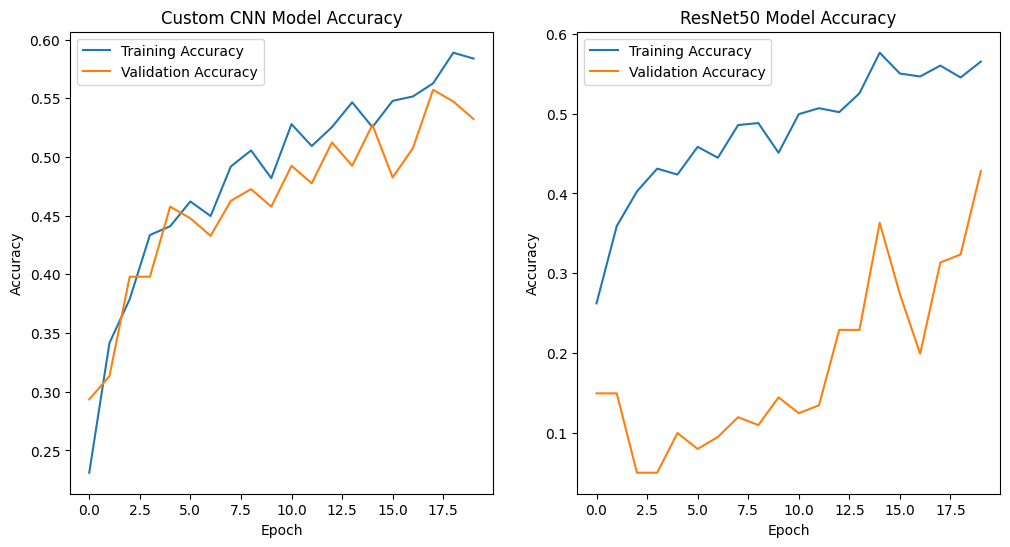

In [16]:
# Plot training and validation accuracy for both models
plt.figure(figsize=(12, 6))

# Custom CNN Model
plt.subplot(1, 2, 1)
plt.plot(history_custom_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_custom_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Custom CNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# ResNet50 Model
plt.subplot(1, 2, 2)
plt.plot(history_resnet50.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet50.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet50 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()



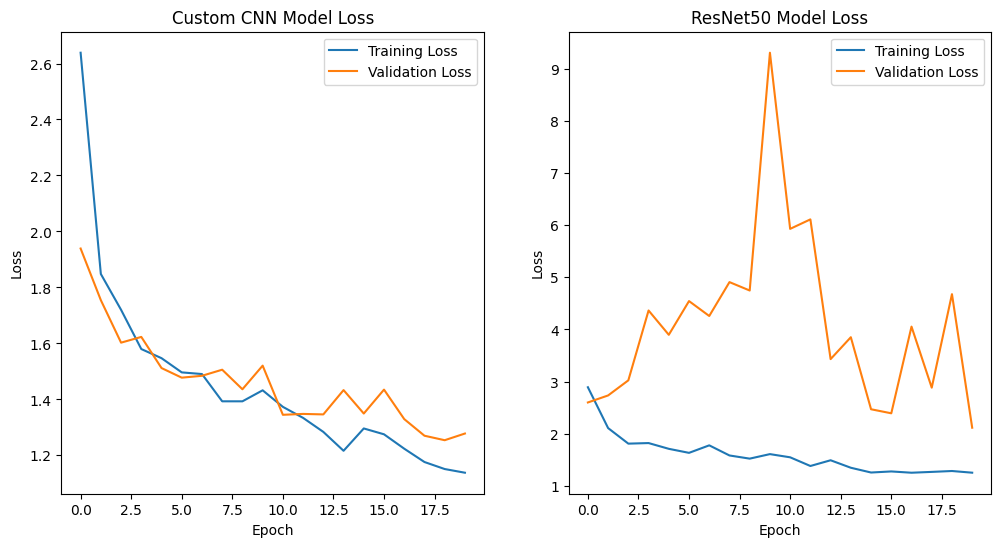

In [17]:
# Plot training and validation loss for both models
plt.figure(figsize=(12, 6))

# Custom CNN Model
plt.subplot(1, 2, 1)
plt.plot(history_custom_cnn.history['loss'], label='Training Loss')
plt.plot(history_custom_cnn.history['val_loss'], label='Validation Loss')
plt.title('Custom CNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# ResNet50 Model
plt.subplot(1, 2, 2)
plt.plot(history_resnet50.history['loss'], label='Training Loss')
plt.plot(history_resnet50.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()